## 1D 컨브넷 구현

- 케라스에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현합니다. 
- `Conv1D`는 `Conv2D`와 인터페이스가 비슷합니다. `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 
- 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

- 간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

(x_train,y_train) , (x_test,y_test) = imdb.load_data(num_words = max_features)
print(len(x_train),'훈련 시퀀스')
print(len(x_test),'테스트 시퀀스')

x_train = sequence.pad_sequences(x_train, maxlen = max_len)
x_test = sequence.pad_sequences(x_test, maxlen = max_len)
print(x_train.shape)
print(x_test.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
(25000, 500)
(25000, 500)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length = max_len))
model.add(layers.Conv1D(32,7,activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,7,activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer = RMSprop(lr = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train,y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 6s 23ms/step - loss: 0.7656 - acc: 0.5184 - val_loss: 0.6882 - val_acc: 0.5276
Epoch 2/10
157/157 [==============================] - 3s 21ms/step - loss: 0.6704 - acc: 0.6536 - val_loss: 0.6723 - val_acc: 0.6304
Epoch 3/10
157/157 [==============================] - 3s 21ms/step - loss: 0.6386 - acc: 0.7552 - val_loss: 0.6388 - val_acc: 0.7206
Epoch 4/10
157/157 [==============================] - 3s 21ms/step - loss: 0.5766 - acc: 0.8082 - val_loss: 0.5504 - val_acc: 0.7840
Epoch 5/10
157/157 [==============================] - 3s 21ms/step - loss: 0.4617 - acc: 0.8341 - val_loss: 0.4349 - val_acc: 0.8276
Epoch 6/10
157/157 [==============================] - 3s 22ms/step - loss: 0.3708 - acc: 0.8622 - val_loss: 0.4039 - val_acc: 0.8442
Epoch 7/10
157/157 [==============================] - 4s 22ms/step - loss: 0.3216 - acc: 0.8819 - val_loss: 0.3984 - val_acc: 0.8536
Epoch 8/10
157/157 [==============================] - 3s 21ms/step - loss: 0.285

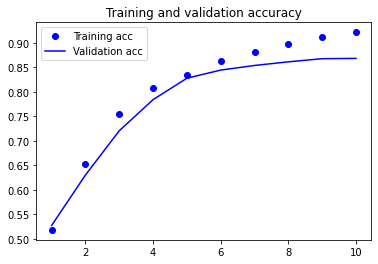

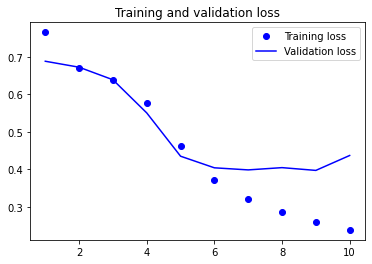

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

검증 정확도는 LSTM 보다는 낮지만 CPU, GPU 에서 더 빠르게 실행된다.  
단어 수준의 감성분류 작업에 순환 네트워크를 대신 하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있다.

CNN과 RNN을 연결하여 긴 시퀀스 처리하기  


In [ ]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Dense, Embedding
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32,5, activation = 'relu',
                 input_shape = (1000, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(Conv1D(32,5, activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(Conv1D(32,5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 996, 32)           2272      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 332, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 328, 32)           5152      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 82, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 78, 32)            5152      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)              

[과제] 상기 건에 대하여 Conv1D를 이용하여 모델 학습 및 검증을 수행한 후 그 성능을 상식 수준의 기준점과 비교하세요.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Embedding
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32,5, activation = 'relu',
                 input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(Conv1D(32,5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(Conv1D(32,5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer= RMSprop(),loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 32s 63ms/step - loss: 0.4215 - val_loss: 0.4518
Epoch 2/20
500/500 [==============================] - 31s 63ms/step - loss: 0.3751 - val_loss: 0.4632
Epoch 3/20
500/500 [==============================] - 32s 63ms/step - loss: 0.3577 - val_loss: 0.4497
Epoch 4/20
500/500 [==============================] - 22s 44ms/step - loss: 0.3479 - val_loss: 0.4490
Epoch 5/20
500/500 [==============================] - 32s 63ms/step - loss: 0.3411 - val_loss: 0.4418
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.3353 - val_loss: 0.4549
Epoch 7/20
500/500 [==============================] - 23s 45ms/step - loss: 0.3288 - val_loss: 0.4476
Epoch 8/20
500/500 [==============================] - 22s 44ms/step - loss: 0.3219 - val_loss: 0.4546
Epoch 9/20
500/500 [==============================] - 22s 45ms/step - loss: 0.3197 - val_loss: 0.4563
Epoch 10/20
500/500 [==============================] - 22s 45ms/step - loss: 0.3170 - val_los

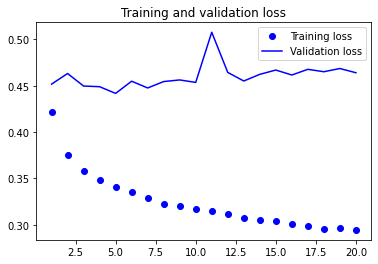

In [ ]:
# 상식수준의 기준점이 0.29보다 성능이 좋지 않다.
# 컨브넷은 시간순서를 고려하지 않기 때문에


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] jena_climate 데이터셋 제너레이터 함수에 step을 6 대신 3으로 변경 적용한 후 상기 과제를 CNN과 RNN을 연결하는 방식으로 수행하고 그 성능에 대하여 평가하세요.

In [ ]:
step = 3 # step을 3으로 변경
lookback = 1440
delay = 144 

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
# CNN과 RNN 결합하여 사용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GRU, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5)) # 2개의 컨브넷층 다음에 RNN층 사용(순환 드롭아웃 적용)
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 452s 876ms/step - loss: 0.3298 - val_loss: 0.2855
Epoch 2/20
500/500 [==============================] - 438s 876ms/step - loss: 0.2946 - val_loss: 0.2747
Epoch 3/20
500/500 [==============================] - 430s 860ms/step - loss: 0.2799 - val_loss: 0.2792
Epoch 4/20
500/500 [==============================] - 429s 858ms/step - loss: 0.2694 - val_loss: 0.2747
Epoch 5/20
500/500 [==============================] - 429s 859ms/step - loss: 0.2624 - val_loss: 0.2744
Epoch 6/20
500/500 [==============================] - 437s 873ms/step - loss: 0.2572 - val_loss: 0.2804
Epoch 7/20
500/500 [==============================] - 435s 870ms/step - loss: 0.2476 - val_loss: 0.2835
Epoch 8/20
500/500 [==============================] - 434s 869ms/step - loss: 0.2443 - val_loss: 0.2827
Epoch 9/20
500/500 [==============================] - 435s 870ms/step - loss: 0.2367 - val_loss: 0.2892
Epoch 10/20
500/500 [==============================] - 435s 869ms/step - lo

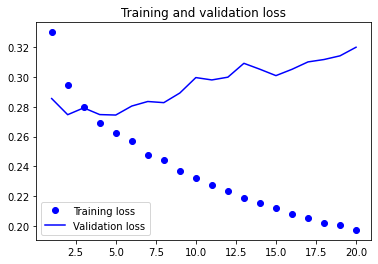

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 상식적인 수준보다 성능이 좋긴 하지만 간단한 GRU보다 성능이 낮다.